# Handwritten digit recognition using a Gaussian generative model

 ## Import Libraries & MNIST
 Split the training set into two pieces - a training set of size 50000, and a separate validation set
of size 10000. Also load in the test data.

In [1]:
from mnist import MNIST
from random import sample, shuffle
import numpy as np
from scipy.stats import multivariate_normal
from collections import defaultdict
import matplotlib.pyplot as plt
import scipy

print "Reading data..."
mndata = MNIST('./mnist_data_files')
images_tv, labels_tv = mndata.load_training()
data_tv = zip(images_tv, labels_tv)
shuffle(data_tv)
data_train = data_tv[:50000]
data_validate = data_tv[50000:]
images_valid, labels_valid = zip(*data_validate)
images_test, labels_test = mndata.load_testing()
# images_test_tmp = images_test_tot[:1000]
# labels_test_tmp = labels_test_tot[:1000]
print "done"

Reading data...
done


## Fit a Gaussian generative model to the training data of 50000 points
### Class Probabilities

In [2]:
data_train_class = defaultdict(list)
for (images, labels) in data_train:
    data_train_class[labels].append(images)

pi = defaultdict(float)
for k in data_train_class.iterkeys():
    pi[k] = len(data_train_class[k]) * 1.0 / len(data_train)

print("pi0 = " + str(pi[0]) + " ;pi1 = " + str(pi[1]) + " ;pi2 = " + str(pi[2]) + " ;pi3 = " + str(pi[3]) + " ;pi4 = " + str(pi[4]) + " ;pi5 = " + str(pi[5]) + " ;pi6 = " + str(pi[6]) + " ;pi7 = " + str(pi[7]) + " ;pi8 = " + str(pi[8]) + " ;pi9 = " + str(pi[9]))

pi0 = 0.09976 ;pi1 = 0.11192 ;pi2 = 0.09904 ;pi3 = 0.10216 ;pi4 = 0.09696 ;pi5 = 0.09084 ;pi6 = 0.0984 ;pi7 = 0.10464 ;pi8 = 0.09812 ;pi9 = 0.09816


### Mean and Cov

In [3]:
mu = defaultdict(np.array)
cov = defaultdict(np.array)

for k in data_train_class.iterkeys():
    mu[k] = sum(np.array(data_train_class[k])) * 1.0 / len(data_train_class[k])
    
def smoothCov(c):
    for k in data_train_class.iterkeys():
        cov[k] = np.cov(np.array(data_train_class[k]).transpose()) +  c * np.eye(len(data_train_class[k][0]))
    return cov

### Fit Gaussian

In [4]:
rvs = defaultdict(dict)
cRange = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 3000, 5000, 10000]

for c in cRange:
    rv = defaultdict(scipy.stats._multivariate.multivariate_normal_frozen)
    for k in data_train_class.iterkeys():
        rv[k] = multivariate_normal(mu[k], smoothCov(c)[k])
    rvs[c] = rv

## Predict

In [6]:
def predict(images, c):
    P = defaultdict(float)
    preLabels = []
    for image in images:
        for v in rv.iterkeys():
            P[v] = np.log(pi[v]) + rvs[c][v].logpdf(image)
        preLabels.append(max(P, key = P.get))      
    return np.array(preLabels)

## Accuracy on Validate Set

In [7]:
acc_valid = defaultdict(float)
for c in cRange:
    acc_valid[c] = sum(predict(images_valid, c) == labels_valid) * 1.0 / len(labels_valid)
    print("acc_valid_" + str(c) + " = " + str(acc_valid[c]))

acc_valid_0.001 = 0.7574
acc_valid_0.01 = 0.7813
acc_valid_0.1 = 0.8078
acc_valid_1 = 0.8362
acc_valid_10 = 0.8744
acc_valid_100 = 0.9163
acc_valid_1000 = 0.9464
acc_valid_3000 = 0.9516
acc_valid_5000 = 0.9507
acc_valid_10000 = 0.9451


## Error on Test Set

In [8]:
acc_test = sum(predict(images_test, 3000) == labels_test) * 1.0 / len(labels_test)
print("test_error_1 = " + str(1 - acc_test))

test_error_1 = 0.042


## Plot Error_valid v.s. c

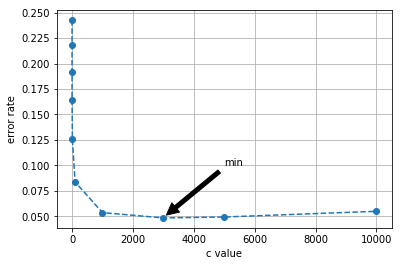

In [9]:
y = []
for c in cRange:
    y.append(1 - acc_valid[c])
plt.plot(cRange, y, 'o--')
plt.xlabel("c value")
plt.ylabel("error rate")
plt.grid(True)
plt.annotate('min', xy=(3000, 0.0487), xytext=(5000, 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05),
             )
plt.savefig("./Err_valid_c.eps")
plt.show()